<div id="singlestore-header" style="display: flex; background-color: rgba(124, 195, 235, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/arrows-spin.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Resume Evaluator with Vector Index</h1>
    </div>
</div>

In this notebook, we will showcase a practical use-case of evaluating resumes leveraging the combined powers of SingleStoreDB and OpenAI. Moving beyond traditional resume-matching techniques, we introduce a method that dives deeper into the nuances of resume content and the specific needs of a job description.

With SingleStoreDB's innate ability to swiftly manage and query data, we begin by ingesting a resume PDF, extracting its textual content, and storing it in a dedicated database table. But we don’t stop there! The resume's text is then processed by OpenAI's LLM, summarizing its key points. This summarized version, along with its vector representation, is saved back to our SingleStoreDB table.

When it's time to match a resume to a job description, we translate the latter into its vector form. Using a dot_product operation, we search against the table housing the resume summaries' embeddings. This provides us with resumes most aligned with the job description. To add another layer of precision, the matched resumes are further evaluated alongside the job description using OpenAI's LLM, offering a comprehensive assessment.

Join us on this journey to redefine resume evaluations using SQL, SingleStoreDB, and OpenAI for better, more insightful matches!

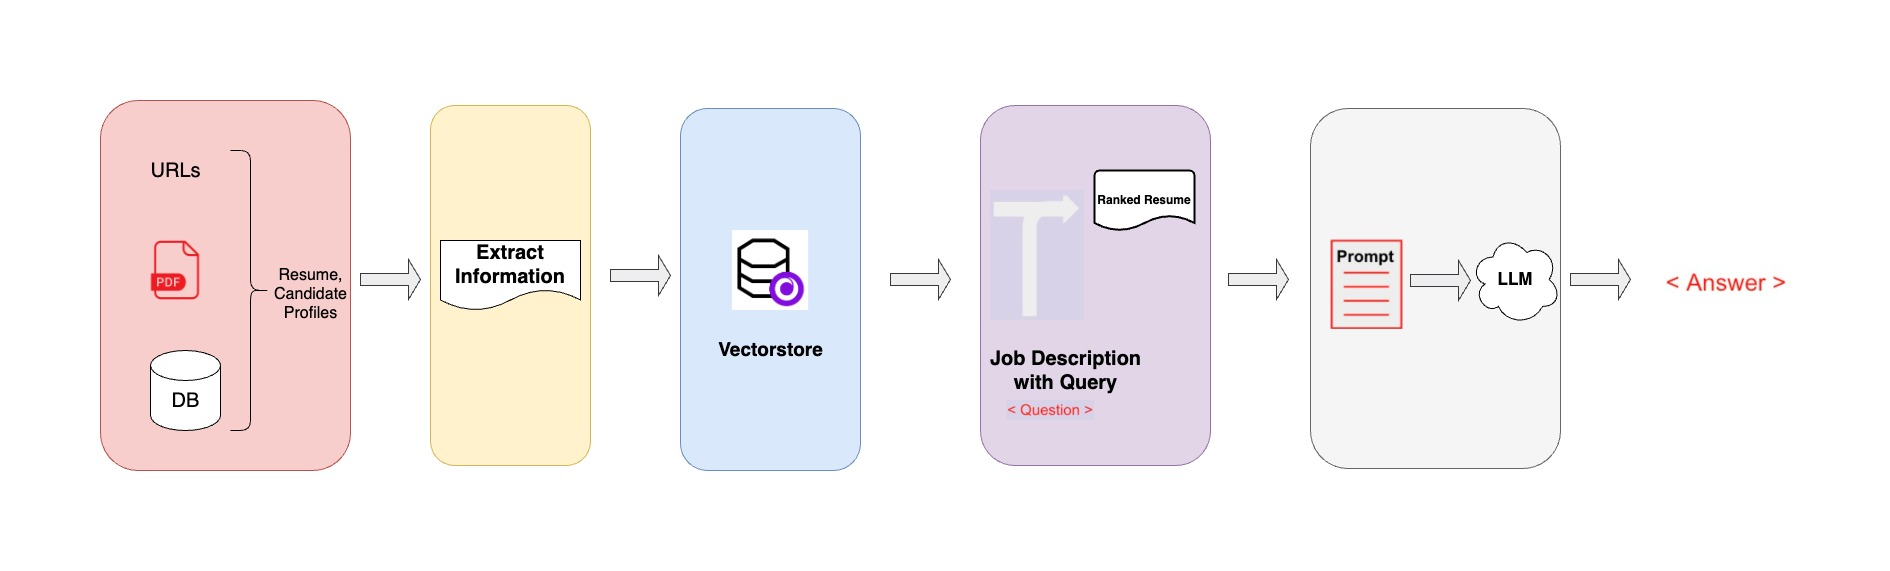

## 1. Create a workspace in your workspace group

S-00 is sufficient.

## 2. Create a database named `resume_evaluator`

#### If you want to use free tier, follow below steps

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p> If you have a Free Starter Workspace deployed already, select the database from drop-down menu at the top of this notebook. It updates the <tt>connection_url</tt> to connect to that database.</p>
    </div>
</div>

In [1]:
shared_tier_check = %sql show variables like 'is_shared_tier'
if not shared_tier_check or shared_tier_check[0][1] == 'OFF':
    %sql DROP DATABASE IF EXISTS new_transactions;
    %sql CREATE DATABASE new_transactions;

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p> Make sure to select a database from the drop-down menu at the top of this notebook. It updates the <tt>connection_url</tt>  to connect to that database.</p>
    </div>
</div>

####
<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Note</b></p>
        <p> If you want to use dedicated workspace, directly select workspace and db from dropdown at the top and follow below steps to create databse.</p>
    </div>
</div>

In [2]:
%%sql
DROP DATABASE IF EXISTS resume_evaluator;
CREATE DATABASE resume_evaluator;
USE resume_evaluator;

In [3]:
%%sql
CREATE TABLE IF NOT EXISTS resume_evaluator.resumes_profile_data(
    names text,
    email text,
    phone_no text,
    years_of_experience text,
    skills text,
    profile_name text,
    resume_summary text,
    resume_embeddings vector(1536, F32)
    );

## 3. Install and import required libraries

In this section, we will set up the necessary environment by installing some crucial libraries. For our task of extracting text from resume PDFs, we'll be using pdfminer.six. To interact with the OpenAI's LLM and manage our data efficiently, openai will be instrumental.

The install process may take a couple minutes.

In [4]:
!pip install -q pdfminer.six openai boto3 sqlalchemy.singlestoredb

In [5]:
import os
import requests
import re
import json
import getpass
from pdfminer.high_level import extract_text
import openai
from openai import OpenAI
import pandas as pd
import numpy as np
from sqlalchemy import text, create_engine

## 4. Create a function called `get_embedding()`
In our workflow, we need a consistent way to transform textual content into vector embeddings. To achieve this, we introduce the get_embedding() function.

This function takes in a piece of text and, by default, uses the "text-embedding-ada-002" model to produce embeddings. We ensure that any newline characters in the text are replaced with spaces to maintain the integrity of the input. The function then leverages OpenAI's API to generate and retrieve the embedding for the given text.

In [6]:
api_key = getpass.getpass('OpenAI API Key: ')
openai.api_key = api_key
client = OpenAI(api_key = api_key)

In [7]:
def get_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    response = openai.embeddings.create(input=[text], model=model)
    return response.data[0].embedding

## 5. Create a function called `print_pdf_text()`

This function is designed to extract and clean the text from a provided PDF, either from a web URL or a local file path.

#### Input:
- `url`: Web URL of the PDF (optional).
- `file_path`: Local path of the PDF (optional).

#### Functionality:
- **Source Determination**:
  - Fetches PDF from `url` or uses the local `file_path`.
  - Raises an error if neither is provided.
- **Text Extraction**: Extracts text from the PDF using `pdfminer`.
- **Text Cleaning**:
  - Removes special characters, retaining only "@", "+", ".", and "/".
  - Improves formatting by handling newline characters.
- **Cleanup**: If a temporary file was created from a URL, it gets deleted post-processing.

#### Output:
Returns the cleaned and formatted text from the PDF.

In [8]:
def print_pdf_text(url=None, file_path=None):
    # Determine the source of the PDF (URL or local file)
    if url:
        response = requests.get(url)
        response.raise_for_status()  # Ensure the request was successful
        temp_file_path = "temp_pdf_file.pdf"
        with open(temp_file_path, 'wb') as temp_file:
            temp_file.write(response.content)  # Save the PDF to a temporary file
        pdf_source = temp_file_path
    elif file_path:
        pdf_source = file_path  # Set the source to the provided local file path
    else:
        raise ValueError("Either url or file_path must be provided.")

    # Extract text using pdfminer
    text = extract_text(pdf_source)

    # Remove special characters except "@", "+", ".", and "/"
    cleaned_text = re.sub(r"[^a-zA-Z0-9\s@+./:,]", "", text)

    # Format the text for better readability
    cleaned_text = cleaned_text.replace("\n\n", " ").replace("\n", " ")
    # If a temporary file was used, delete it
    if url and os.path.exists(temp_file_path):
        os.remove(temp_file_path)

    return cleaned_text

## 6. Create a function called `pinfo_extractor()`

This function is tailored to extract specific details from a candidate's resume text.

### Input:
- `resume_text`: The text extracted from a candidate's resume.

### Functionality:
- **Prompt Creation**:
  - A context is formed using the provided resume text.
  - A detailed question prompt is generated to guide the extraction of desired details from the resume.
- **OpenAI API Interaction**:
  - Uses the `gpt-3.5-turbo` model to process the prompt and generate a detailed extraction.
  - Extracts relevant sections like Name, Email, Phone Number, and more from the generated response.
- **Data Structuring**:
  - The extracted details are organized into a dictionary.

### Output:
Returns a dictionary with keys such as 'name', 'email', 'phone_no', and more, containing extracted information from the resume.

In [9]:
def pinfo_extractor(resume_text):
    context = f"Resume text: {resume_text}"
    question = """ From above candidate's resume text, extract the only following details:
                Name: (Find the candidate's full name. If not available, specify "not available.")
                Email: (Locate the candidate's email address. If not available, specify "not available.")
                Phone Number: (Identify the candidate's phone number. If not found, specify "not available.")
                Years of Experience: (If not explicitly mentioned, calculate the years of experience by analyzing the time durations at each company or position listed. Sum up the total durations to estimate the years of experience. If not determinable, write "not available.")
                Skills Set: Extract the skills which are purely technical and represent them as: [skill1, skill2,... <other skills from resume>]. If no skills are provided, state "not available."
                Profile: (Identify the candidate's job profile or designation. If not mentioned, specify "not available.")
                Summary: provide a brief summary of the candidate's profile without using more than one newline to segregate sections.
                """

    prompt = f"""
        Based on the below given candidate information, only answer asked question:
        {context}
        Question: {question}
    """
    # print(prompt)
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful HR recruiter."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=700,
        temperature=0.5,
        n=1  # assuming you want one generation per document
    )
    # Extract the generated response
    response_text = response.choices[0].message.content # response['choices'][0]['message']['content']
    # print(response_text)
    # Split the response_text into lines
    lines = response_text.strip().split('\n')

    # Now, split each line on the colon to separate the labels from the values
    # Extract the values
    name = lines[0].split(': ')[1]
    email = lines[1].split(': ')[1]
    phone_no = lines[2].split(': ')[1]
    years_of_expiernce = lines[3].split(': ')[1]
    skills = lines[4].split(': ')[1]
    profile = lines[5].split(': ')[1]
    summary = lines[6].split(': ')[1]
    data_dict = {
        'name': name,
        'email': email,
        'phone_no': phone_no,
        'years_of_expiernce': years_of_expiernce,
        'skills': skills,
        'profile': profile,
        'summary': summary
    }
    # print(data_dict, "\n")
    return data_dict;

## 7. Create a function called `add_data_to_db()`

This function is designed to add extracted resume details into a database.

### Input:
- `input_dict`: Dictionary containing details like 'name', 'email', 'phone_no', and more extracted from a resume.

### Functionality:
- **Database Connection**:
  - Establishes a connection to the database using SQLAlchemy's `create_engine` with the given connection URL.
- **Embedding Creation**:
  - Calls the `get_embedding()` function to generate an embedding for the resume summary.
- **SQL Query Formation**:
  - Crafts an SQL query to insert the provided data (from the input dictionary) into the `resumes_profile_data` table in the database.
- **Data Insertion**:
  - Opens a connection, executes the SQL query, commits the changes, and then closes the connection.

### Output:
Prints a confirmation message upon successful data insertion.

In [10]:
def add_data_to_db(input_dict):
    # Create the SQLAlchemy engine
    engine = create_engine(f'singlestoredb://{connection_user}:{connection_password}@{connection_host}:{connection_port}/resume_evaluator')

    engine = create_engine(connection_url)
    # Get the embedding for the summary text
    summary = input_dict['summary']
    embedding = get_embedding(summary)
    # Create the SQL query for inserting the data
    query_sql = f"""
        INSERT INTO resumes_profile_data (names, email, phone_no, years_of_experience, skills, profile_name, resume_summary, resume_embeddings)
        VALUES ("{input_dict['name']}", "{input_dict['email']}", "{input_dict['phone_no']}", "{input_dict['years_of_expiernce']}",
        "{input_dict['skills']}", "{input_dict['profile']}", "{summary}", '{embedding}');
    """
    with engine.connect() as connection:
        connection.execute(text(query_sql))
        connection.commit()
    #print("\nData Written to resumes_profile_data_2 table")
    connection.close()

## 8. Create a function called `search_resumes()`

This function facilitates the search for resumes that are most similar to a given query, leveraging embeddings and database operations.

### Input:
- `query`: A string that represents the job description or any other search criteria.

### Functionality:
- **Embedding Creation**:
  - Converts the given `query` into its corresponding embedding using the `get_embedding()` function.
- **SQL Query Formation**:
  - Creates an SQL query to search for the top 5 resumes in the `resumes_profile_data` table that have the highest similarity (dot product) to the query embedding.
- **Database Operations**:
  - Opens a connection to the database, runs the SQL query to fetch the results, and then closes the connection.

### Output:
Returns a list of the top 5 most relevant resumes based on the given query.

In [11]:
def search_resumes(query):
    query_embed = get_embedding(query)
    query_sql = f"""
            SELECT names, resume_summary, dot_product(
            '{query_embed}':> VECTOR(1536), resume_embeddings
                ) AS similarity
                FROM resumes_profile_data
                ORDER BY similarity DESC
                LIMIT 5;
    """
    # print(query_sql,"\n")
    # engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database_name}')
    engine = create_engine(connection_url)
    connection = engine.connect()
    result = connection.execute(text(query_sql)).fetchall()
    connection.close()
    engine.dispose()
    return result

## 9. Create a function called `evaluate_candidates()`

This function is geared towards evaluating the compatibility of candidates' resumes in relation to a specific job description.

### Input:
- `query`: A string that represents the job description against which candidates' resumes will be assessed.

### Functionality:
- **Resume Retrieval**:
  - Utilizes the `search_resumes()` function to get the top matching resumes based on the job description.
- **OpenAI API Interaction**:
  - For each retrieved resume, a prompt is crafted, asking to evaluate how well the candidate fits the job description.
  - Interacts with the `gpt-3.5-turbo` model to process this prompt and receive an efficient, concise response.
- **Data Aggregation**:
  - Collects the model's evaluation responses for each candidate in a list.

### Output:
Returns a list of tuples, where each tuple contains:
- Candidate's name.
- Evaluation response from the model, describing the compatibility of the candidate with the given job description.

In [12]:
def evaluate_candidates(query):
    result = search_resumes(query)
    responses = []  # List to store responses for each candidate
    for resume_str in result:
        name = resume_str[0]
        context = f"Resume text: {resume_str[1]}"
        question = f"How does the candidate meet for the following job description? Is he/she fit for the given profiles/roles and responsibilities ?answer in 3 lines only and be effcient while answering: {query}."
        prompt = f"""
            Read below candidate information about the candidate:
            {context}
            Question: {question}
        """
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a expert HR analyst and recuriter."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=100,
            temperature=0.2,
            n=1  # assuming you want one generation per document
        )
        # Extract the generated response
        response_text = response.choices[0].message.content # response['choices'][0]['message']['content']
        responses.append((name, response_text))  # Append the name and response_text to the responses list
    return responses

In [13]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config

def list_s3_files(bucket_name, prefix):
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    paginator = s3.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

    urls = []
    for page in page_iterator:
        if "Contents" in page:
            for obj in page['Contents']:
                object_url = f"https://{bucket_name}.s3.amazonaws.com/{obj['Key']}"
                urls.append(object_url)

    return urls

bucket_name = 'real-time-anomaly-detection-demo'
path_prefix = 'resume-eval/'

urls = list_s3_files(bucket_name, path_prefix)
# urls

In [14]:
# You can use above urls list, for demo purpose we are using below only
urls = [
'https://real-time-anomaly-detection-demo.s3.amazonaws.com/resume-eval/16b67c12-62e9-4d81-8f9f-ef3112daee13.pdf',
'https://real-time-anomaly-detection-demo.s3.amazonaws.com/resume-eval/1a394211-8074-4a88-a6ce-70c1d83f8a49.pdf',
'https://real-time-anomaly-detection-demo.s3.amazonaws.com/resume-eval/1f7f185a-3629-45d8-a21a-7fd57ee541af.pdf',
'https://real-time-anomaly-detection-demo.s3.amazonaws.com/resume-eval/21590a01-b5f7-4739-81b5-6aca293cc80a.pdf',
'https://real-time-anomaly-detection-demo.s3.amazonaws.com/resume-eval/22f701ff-6402-463b-8b7c-d5c252607763.pdf']
for url in urls:
    resume_text = print_pdf_text(url=url).replace('\n',' ')
    #print("Resume Text extracted\n")
    ip_data_dict = pinfo_extractor(resume_text)
    #print("Information extracted\n")
    add_data_to_db(ip_data_dict)
    # print("\n")

In [15]:
%%sql
SELECT COUNT(*) FROM resumes_profile_data;

## 10. Using Vector Index in SingleStore

Vector indexes in SingleStore enhance query performance for high-dimensional data, commonly used in machine learning, search applications, and recommendation systems. Understanding when and why to use each type of vector index is crucial for optimizing your database's performance and storage efficiency.

### Types of Vector Indexes

#### FLAT
- **When to Use**: Small datasets or when exact nearest neighbors are required.
- **Why**: Performs a full scan, ensuring the most accurate results but can be slower on large datasets.

#### HNSW (Hierarchical Navigable Small World)
- **When to Use**: General-purpose, suitable for a broad range of datasets.
- **Why**: Balances speed and accuracy well, efficient for both small and large datasets. Offers faster queries by constructing a multi-layered graph structure.

#### IVF (Inverted File Index)
- **When to Use**: Large datasets where query speed is critical, and approximate results are acceptable.
- **Why**: Divides the dataset into clusters to reduce the search area, significantly increasing query speed at the cost of slight accuracy loss.

### Choosing the Right Index

- **Dataset Size**: For smaller datasets or when absolute accuracy is paramount, `FLAT` is suitable. For larger datasets or when query performance is a priority, consider `HNSW` or `IVF`.
- **Query Speed vs. Accuracy**: If your application requires the fastest possible queries and can tolerate approximate results, `IVF` is recommended. For a good balance between speed and accuracy, `HNSW` is often the best choice.
- **Application Requirements**: Recommendation systems and content similarity searches often benefit from `HNSW` due to its efficiency and balance. Exact match searches or smaller datasets may lean towards `FLAT`.


Selecting the right vector index depends on your specific application needs, the size of your dataset, and the balance you wish to strike between query speed and accuracy. Experimenting with different index types and configurations is key to finding the optimal setup for your use case.

In [16]:
%%sql
ALTER TABLE resumes_profile_data
ADD VECTOR INDEX ivf_flat (new_resume_embeddings) INDEX_OPTIONS '{"index_type":"IVF_FLAT"}';

In [17]:
evaluate_candidates(input("Enter Job description : \n"))

## Clean up

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p> If you created a new database in your Standard or Premium Workspace, you can drop the database by running the cell below. Note: this will not drop your database for Free Starter Workspaces. To drop a Free Starter Workspace, terminate the Workspace using the UI. </p>
    </div>
</div>

In [18]:
shared_tier_check = %sql show variables like 'is_shared_tier'
if not shared_tier_check or shared_tier_check[0][1] == 'OFF':
    %sql DROP DATABASE IF EXISTS new_transactions;

<div id="singlestore-footer" style="background-color: rgba(194, 193, 199, 0.25); height:2px; margin-bottom:10px"></div>
<div><img src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/singlestore-logo-grey.png" style="padding: 0px; margin: 0px; height: 24px"/></div>